<a href="https://colab.research.google.com/github/fsternini/prod-opt/blob/development/prod_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intro

In [310]:
# First, verification of Python version is completed
!which python # should return /usr/local/bin/python
!python --version

/usr/local/bin/python
Python 3.10.12


In [311]:
!git clone 'https://github.com/fsternini/prod-opt.git'
%cd 'prod-opt'
# Switch to the most updated branch
!git switch development
# Collect the most updated version of the repo
!git pull

Cloning into 'prod-opt'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 17 (delta 4), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (17/17), 5.33 KiB | 5.33 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/prod-opt/prod-opt/prod-opt/prod-opt
Branch 'development' set up to track remote branch 'development' from 'origin'.
Switched to a new branch 'development'
Already up to date.


In [312]:
# Install all requirements for the code
!pip install -r requirements.txt -q
# Google Drive is mounted, to reach and save all relevant data
from google.colab import drive
import os
import colab_env
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt


drive.mount('/content/drive')
dataset_path = os.environ['PROD_DATASET']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data loading

In [313]:
df = pd.read_csv(dataset_path+"/training_set_data_science.tsv", delimiter="\t")

The number of samples is obtained for each class

In [314]:
df.groupby("class").count()

,id,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74
class,,,,,,,,,,,,,,,,,,,,,
0.0,111,111,111,111,111,111,111,111,111,111,...,111,111,111,111,111,111,111,111,111,111
0.5,54,54,54,54,54,54,54,54,54,54,...,54,54,54,54,54,54,54,54,54,54
1.0,1284,1284,1284,1284,1284,1284,1284,1284,1284,1284,...,1284,1284,1284,1284,1284,1284,1284,1284,1284,1284


The dataset is highly imbalanced, therefore some solutions with underrepresented classes could be considered

In [315]:
df.isnull().sum().unique()

array([0])

No missing values are found in the datasaet, so no further actions are required

In [316]:
for i in df.columns:
  print(df[i].dtypes)

float64
int64
float64
float64
float64
float64
int64
int64
float64
float64
float64
float64
float64
int64
int64
float64
float64
float64
float64
float64
int64
int64
float64
float64
float64
float64
float64
int64
int64
int64
float64
float64
float64
float64
int64
int64
float64
float64
float64
float64
float64
int64
int64
float64
float64
float64
float64
float64
int64
int64
float64
int64
int64
float64
int64
int64
int64
float64
int64
int64
int64
int64
float64
int64
int64
int64
float64
int64
int64
float64
float64
int64
float64
float64
float64
float64


All the categories are numerical

In [317]:
df['class']=df["class"].replace({0:"fail",0.5:"low",1.0:"success"})

In [318]:
df.groupby("class").count()

,id,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74
class,,,,,,,,,,,,,,,,,,,,,
fail,111,111,111,111,111,111,111,111,111,111,...,111,111,111,111,111,111,111,111,111,111
low,54,54,54,54,54,54,54,54,54,54,...,54,54,54,54,54,54,54,54,54,54
success,1284,1284,1284,1284,1284,1284,1284,1284,1284,1284,...,1284,1284,1284,1284,1284,1284,1284,1284,1284,1284


In [319]:
df.head()
X=np.array(df.drop(["class","id"],axis=1))

In [320]:
y = np.array(df["class"])

#1st iteration


First a set of classifiers are developed with all the classes

The k-fold technique is used to identify the most promising and robust technique before the test with production data (the test dataset provided)

In [321]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
print(skf)

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


considering the high number of variables, the first choice is to use SVM, to use its capabilities of linear separation of data in high dimensionality

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


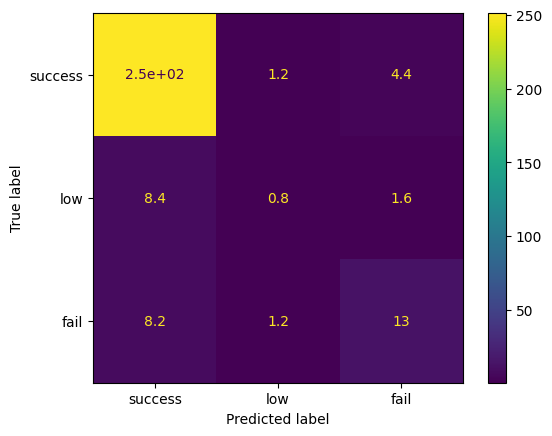

{'SVM': {'Fold_0': {'success': {'Precision': 0.9296296296296296, 'Recall': 0.9766536964980544, 'FScore': 0.9525616698292219, 'Support': 257}, 'low': {'Precision': 0.0, 'Recall': 0.0, 'FScore': 0.0, 'Support': 11}, 'fail': {'Precision': 0.6875, 'Recall': 0.5, 'FScore': 0.5789473684210527, 'Support': 22}}, 'Fold_1': {'success': {'Precision': 0.9609375, 'Recall': 0.9571984435797666, 'FScore': 0.9590643274853801, 'Support': 257}, 'low': {'Precision': 0.3333333333333333, 'Recall': 0.2727272727272727, 'FScore': 0.3, 'Support': 11}, 'fail': {'Precision': 0.64, 'Recall': 0.7272727272727273, 'FScore': 0.6808510638297872, 'Support': 22}}, 'Fold_2': {'success': {'Precision': 0.933579335793358, 'Recall': 0.9844357976653697, 'FScore': 0.9583333333333334, 'Support': 257}, 'low': {'Precision': 0.0, 'Recall': 0.0, 'FScore': 0.0, 'Support': 11}, 'fail': {'Precision': 0.631578947368421, 'Recall': 0.5454545454545454, 'FScore': 0.5853658536585366, 'Support': 22}}, 'Fold_3': {'success': {'Precision': 0.923

In [322]:
clf = make_pipeline(StandardScaler(), LinearSVC(dual=False,
                                                random_state=0, tol=1e-5))
labels = ["success","low","fail"]
results={"SVM":{}}
cm=np.zeros((5,len(labels),len(labels)))
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
  x_train = X[train_index]
  y_train = y[train_index]
  x_test = X[test_index]
  y_test = y[test_index]
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
  fold = "Fold_"+str(i)
  results["SVM"][fold]={}
  for j in range(len(labels)):
    results["SVM"][fold][labels[j]] = {"Precision":precision[j],
                          "Recall":recall[j],
                          "FScore":fscore[j],
                          "Support":support[j]
                                }
  cm[i]=confusion_matrix(y_test, y_pred, labels=labels)

cm=np.average(cm,axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(results)

Considering the need of reducing false positives to reduce the impact on the production, the Recall in the fail class shall be considered as prioritary and therefore is analyzed

In [226]:
recalls={"SVM":[]}
for key in results["SVM"]:
  recalls["SVM"].append(results["SVM"][key]["fail"]["Recall"])

to improve the performance in underrepresented categories, the SMOTE technique is tested

In [227]:
resampler = SMOTE(sampling_strategy="not majority", random_state=42)

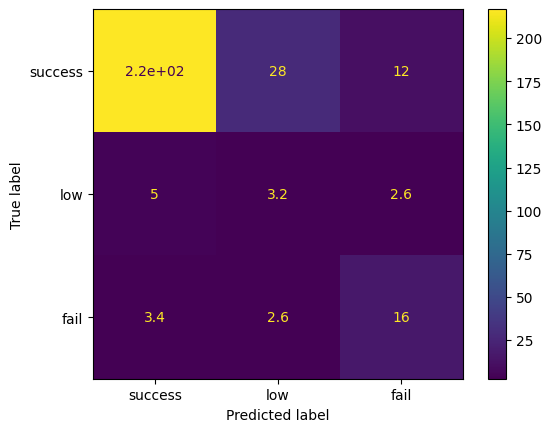

{'SVM': {'Fold_0': {'success': {'Precision': 0.9296296296296296, 'Recall': 0.9766536964980544, 'FScore': 0.9525616698292219, 'Support': 257}, 'low': {'Precision': 0.0, 'Recall': 0.0, 'FScore': 0.0, 'Support': 11}, 'fail': {'Precision': 0.6875, 'Recall': 0.5, 'FScore': 0.5789473684210527, 'Support': 22}}, 'Fold_1': {'success': {'Precision': 0.9609375, 'Recall': 0.9571984435797666, 'FScore': 0.9590643274853801, 'Support': 257}, 'low': {'Precision': 0.3333333333333333, 'Recall': 0.2727272727272727, 'FScore': 0.3, 'Support': 11}, 'fail': {'Precision': 0.64, 'Recall': 0.7272727272727273, 'FScore': 0.6808510638297872, 'Support': 22}}, 'Fold_2': {'success': {'Precision': 0.933579335793358, 'Recall': 0.9844357976653697, 'FScore': 0.9583333333333334, 'Support': 257}, 'low': {'Precision': 0.0, 'Recall': 0.0, 'FScore': 0.0, 'Support': 11}, 'fail': {'Precision': 0.631578947368421, 'Recall': 0.5454545454545454, 'FScore': 0.5853658536585366, 'Support': 22}}, 'Fold_3': {'success': {'Precision': 0.923

In [326]:
clf = make_pipeline(StandardScaler(), LinearSVC(dual=False,
                                                random_state=0, tol=1e-5))
results["SVM_RES"]={}
cm=np.zeros((5,len(labels),len(labels)))
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
  x_train = X[train_index]
  y_train = y[train_index]
  x_test = X[test_index]
  y_test = y[test_index]
  x_res, y_res = resampler.fit_resample(x_train,y_train)
  clf.fit(x_res, y_res)
  y_pred = clf.predict(x_test)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
  fold = "Fold_"+str(i)
  results["SVM_RES"][fold]={}
  for j in range(len(labels)):
    results["SVM_RES"][fold][labels[j]] = {"Precision":precision[j],
                          "Recall":recall[j],
                          "FScore":fscore[j],
                          "Support":support[j]
                                }
  cm[i]=confusion_matrix(y_test, y_pred, labels=labels)

cm=np.average(cm,axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(results)
recalls["SVM_RES"]=[]
for key in results["SVM_RES"]:
  recalls["SVM_RES"].append(results["SVM_RES"][key]["fail"]["Recall"])

The third trial is related to the adoption of Extreme Gradient Boosting algorithms, known to be extremely efficient in the classification

[0]	validation_0-mlogloss:0.77169
[1]	validation_0-mlogloss:0.59556
[2]	validation_0-mlogloss:0.48729
[3]	validation_0-mlogloss:0.41547
[4]	validation_0-mlogloss:0.36865
[5]	validation_0-mlogloss:0.33559
[6]	validation_0-mlogloss:0.31253
[7]	validation_0-mlogloss:0.29769
[8]	validation_0-mlogloss:0.28901
[9]	validation_0-mlogloss:0.28403
[10]	validation_0-mlogloss:0.28098
[11]	validation_0-mlogloss:0.27893
[12]	validation_0-mlogloss:0.28071
[13]	validation_0-mlogloss:0.28314
[0]	validation_0-mlogloss:0.77387
[1]	validation_0-mlogloss:0.59681
[2]	validation_0-mlogloss:0.47570
[3]	validation_0-mlogloss:0.40013
[4]	validation_0-mlogloss:0.34229
[5]	validation_0-mlogloss:0.30572
[6]	validation_0-mlogloss:0.27885
[7]	validation_0-mlogloss:0.25786
[8]	validation_0-mlogloss:0.24822
[9]	validation_0-mlogloss:0.23859
[10]	validation_0-mlogloss:0.23227
[11]	validation_0-mlogloss:0.22588
[12]	validation_0-mlogloss:0.22433
[13]	validation_0-mlogloss:0.22315
[14]	validation_0-mlogloss:0.22444
[0]	v

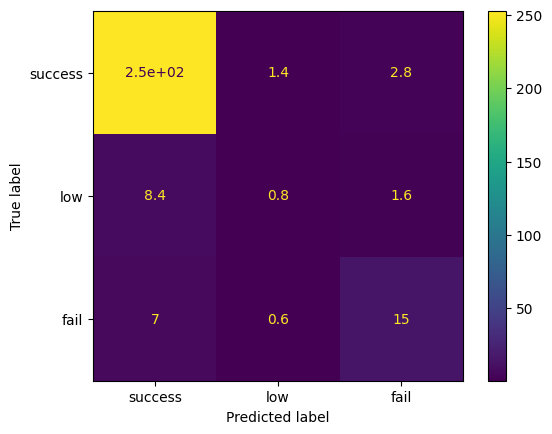

{'SVM': {'Fold_0': {'success': {'Precision': 0.9296296296296296, 'Recall': 0.9766536964980544, 'FScore': 0.9525616698292219, 'Support': 257}, 'low': {'Precision': 0.0, 'Recall': 0.0, 'FScore': 0.0, 'Support': 11}, 'fail': {'Precision': 0.6875, 'Recall': 0.5, 'FScore': 0.5789473684210527, 'Support': 22}}, 'Fold_1': {'success': {'Precision': 0.9609375, 'Recall': 0.9571984435797666, 'FScore': 0.9590643274853801, 'Support': 257}, 'low': {'Precision': 0.3333333333333333, 'Recall': 0.2727272727272727, 'FScore': 0.3, 'Support': 11}, 'fail': {'Precision': 0.64, 'Recall': 0.7272727272727273, 'FScore': 0.6808510638297872, 'Support': 22}}, 'Fold_2': {'success': {'Precision': 0.933579335793358, 'Recall': 0.9844357976653697, 'FScore': 0.9583333333333334, 'Support': 257}, 'low': {'Precision': 0.0, 'Recall': 0.0, 'FScore': 0.0, 'Support': 11}, 'fail': {'Precision': 0.631578947368421, 'Recall': 0.5454545454545454, 'FScore': 0.5853658536585366, 'Support': 22}}, 'Fold_3': {'success': {'Precision': 0.923

In [328]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
y_enc = label_encoder.transform(y)

model = xgb.XGBClassifier(early_stopping_rounds=2)
clf_xgb = make_pipeline(model)
results["XGB"]={}
cm=np.zeros((5,len(labels),len(labels)))
for i, (train_index, test_index) in enumerate(skf.split(X, y_enc)):
  x_train = X[train_index]
  y_train = y_enc[train_index]
  x_test = X[test_index]
  y_test = y_enc[test_index]
  clf_xgb.fit(x_train, y_train, xgbclassifier__eval_set=[(x_test, y_test)])
  y_pred = clf_xgb.predict(x_test)
  y_pred = label_encoder.inverse_transform(y_pred)
  y_test = label_encoder.inverse_transform(y_test)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
  fold = "Fold_"+str(i)
  results["XGB"][fold]={}
  for j in range(len(labels)):
    results["XGB"][fold][labels[j]] = {"Precision":precision[j],
                          "Recall":recall[j],
                          "FScore":fscore[j],
                          "Support":support[j]
                                }
  cm[i]=confusion_matrix(y_test, y_pred, labels=labels)

cm=np.average(cm,axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(results)
recalls["XGB"]=[]
for key in results["XGB"]:
  recalls["XGB"].append(results["XGB"][key]["fail"]["Recall"])

First is tried without any resampling, and then with resampling strategies

[0]	validation_0-mlogloss:0.81608
[1]	validation_0-mlogloss:0.65304
[2]	validation_0-mlogloss:0.54928
[3]	validation_0-mlogloss:0.47291
[4]	validation_0-mlogloss:0.40968
[5]	validation_0-mlogloss:0.36835
[6]	validation_0-mlogloss:0.34870
[7]	validation_0-mlogloss:0.33209
[8]	validation_0-mlogloss:0.32165
[9]	validation_0-mlogloss:0.31742
[10]	validation_0-mlogloss:0.31234
[11]	validation_0-mlogloss:0.30730
[12]	validation_0-mlogloss:0.30583
[13]	validation_0-mlogloss:0.30985
[14]	validation_0-mlogloss:0.31090
[0]	validation_0-mlogloss:0.82881
[1]	validation_0-mlogloss:0.66709
[2]	validation_0-mlogloss:0.55757
[3]	validation_0-mlogloss:0.48099
[4]	validation_0-mlogloss:0.42137
[5]	validation_0-mlogloss:0.38347
[6]	validation_0-mlogloss:0.34963
[7]	validation_0-mlogloss:0.32987
[8]	validation_0-mlogloss:0.31604
[9]	validation_0-mlogloss:0.29823
[10]	validation_0-mlogloss:0.28566
[11]	validation_0-mlogloss:0.27422
[12]	validation_0-mlogloss:0.26577
[13]	validation_0-mlogloss:0.26380
[14]	

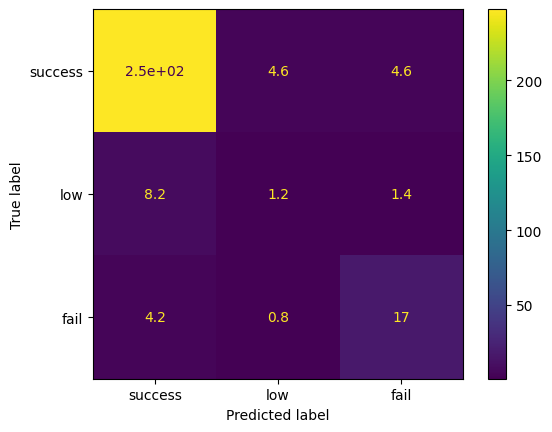

{'SVM': {'Fold_0': {'success': {'Precision': 0.9296296296296296, 'Recall': 0.9766536964980544, 'FScore': 0.9525616698292219, 'Support': 257}, 'low': {'Precision': 0.0, 'Recall': 0.0, 'FScore': 0.0, 'Support': 11}, 'fail': {'Precision': 0.6875, 'Recall': 0.5, 'FScore': 0.5789473684210527, 'Support': 22}}, 'Fold_1': {'success': {'Precision': 0.9609375, 'Recall': 0.9571984435797666, 'FScore': 0.9590643274853801, 'Support': 257}, 'low': {'Precision': 0.3333333333333333, 'Recall': 0.2727272727272727, 'FScore': 0.3, 'Support': 11}, 'fail': {'Precision': 0.64, 'Recall': 0.7272727272727273, 'FScore': 0.6808510638297872, 'Support': 22}}, 'Fold_2': {'success': {'Precision': 0.933579335793358, 'Recall': 0.9844357976653697, 'FScore': 0.9583333333333334, 'Support': 257}, 'low': {'Precision': 0.0, 'Recall': 0.0, 'FScore': 0.0, 'Support': 11}, 'fail': {'Precision': 0.631578947368421, 'Recall': 0.5454545454545454, 'FScore': 0.5853658536585366, 'Support': 22}}, 'Fold_3': {'success': {'Precision': 0.923

In [330]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
y_enc = label_encoder.transform(y)

model = xgb.XGBClassifier(early_stopping_rounds=2)
clf_xgb = make_pipeline(model)

results["XGB_res"]={}
cm=np.zeros((5,len(labels),len(labels)))
for i, (train_index, test_index) in enumerate(skf.split(X, y_enc)):
  x_train = X[train_index]
  y_train = y_enc[train_index]
  x_test = X[test_index]
  y_test = y_enc[test_index]
  x_res, y_res = resampler.fit_resample(x_train,y_train)
  clf_xgb.fit(x_res, y_res, xgbclassifier__eval_set=[(x_test, y_test)])
  y_pred = clf_xgb.predict(x_test)
  y_pred = label_encoder.inverse_transform(y_pred)
  y_test = label_encoder.inverse_transform(y_test)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
  fold = "Fold_"+str(i)
  results["XGB_res"][fold]={}
  for j in range(len(labels)):
    results["XGB_res"][fold][labels[j]] = {"Precision":precision[j],
                          "Recall":recall[j],
                          "FScore":fscore[j],
                          "Support":support[j]
                                }
  cm[i]=confusion_matrix(y_test, y_pred, labels=labels)

cm=np.average(cm,axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(results)
recalls["XGB_res"]=[]
for key in results["XGB_res"]:
  recalls["XGB_res"].append(results["XGB_res"][key]["fail"]["Recall"])

In [331]:
rec =[]
titles = []
for key, value in recalls.items():
  titles.append(key)
  rec.append(value)

Text(0.5, 1.0, 'Recall of fail class')

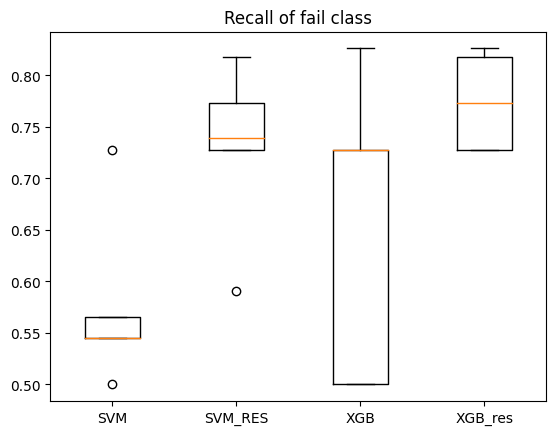

In [332]:
plt.boxplot(rec,labels=titles)
plt.title("Recall of fail class")

As can be seen, the results are far from excellent, but the most promising results are obtained by the XGB with resampling technique based on the SMOTE technique

#2nd iteration

Same approach is tested with the merge of the two categories success and low before any resampling technique

In [234]:
y = np.array(df["class"])

In [235]:
ym = np.array(y, copy=True)
ym[ym=="low"]="success"

First a set of classifieris is developed with all the classes

The k-fold technique is used to identifym the most promising and robust technique before the test with production data (the test dataset provided)

In [236]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
print(skf)

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


considering the high number of variables, the first choice is to use SVM, to use its capabilities of linear separation of data in high dimensionality

In [237]:
clf = make_pipeline(StandardScaler(), LinearSVC(dual=False,
                                                random_state=0, tol=1e-5))
labels = ["success","fail"]
results_m={"SVM":{}}
cm=np.zeros((5,len(labels),len(labels)))

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
  x_train = X[train_index]
  y_train = ym[train_index]
  x_test = X[test_index]
  y_test = ym[test_index]
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
  fold = "Fold_"+str(i)
  results_m["SVM"][fold]={}
  for j in range(len(labels)):
    results_m["SVM"][fold][labels[j]] = {"Precision":precision[j],
                          "Recall":recall[j],
                          "FScore":fscore[j],
                          "Support":support[j]
                                }
  cm[i]=confusion_matrix(y_test, y_pred, labels=labels)

cm=np.average(cm,axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(results_m)


{'SVM': {'Fold_0': {'success': {'Precision': 0.96, 'Recall': 0.9850746268656716, 'FScore': 0.9723756906077348, 'Support': 268}, 'fail': {'Precision': 0.7333333333333333, 'Recall': 0.5, 'FScore': 0.5945945945945945, 'Support': 22}}, 'Fold_1': {'success': {'Precision': 0.9735849056603774, 'Recall': 0.9626865671641791, 'FScore': 0.9681050656660413, 'Support': 268}, 'fail': {'Precision': 0.6, 'Recall': 0.6818181818181818, 'FScore': 0.6382978723404256, 'Support': 22}}, 'Fold_2': {'success': {'Precision': 0.9633699633699634, 'Recall': 0.9813432835820896, 'FScore': 0.9722735674676525, 'Support': 268}, 'fail': {'Precision': 0.7058823529411765, 'Recall': 0.5454545454545454, 'FScore': 0.6153846153846153, 'Support': 22}}, 'Fold_3': {'success': {'Precision': 0.9636363636363636, 'Recall': 0.9888059701492538, 'FScore': 0.9760589318600369, 'Support': 268}, 'fail': {'Precision': 0.8, 'Recall': 0.5454545454545454, 'FScore': 0.6486486486486486, 'Support': 22}}, 'Fold_4': {'success': {'Precision': 0.9664

In [238]:
recalls_m={"SVM":[]}
for key in results_m["SVM"]:
  recalls_m["SVM"].append(results_m["SVM"][key]["fail"]["Recall"])

In [239]:
recalls_m

{'SVM': [0.5,
  0.6818181818181818,
  0.5454545454545454,
  0.5454545454545454,
  0.6086956521739131]}

to improve the performance in underrepresented categories, the SMOTE technique is tested

In [240]:
resampler = SMOTE(sampling_strategy="not majority", random_state=42)

In [241]:
clf = make_pipeline(StandardScaler(), LinearSVC(dual=False,
                                                random_state=0, tol=1e-5))
cm=np.zeros((5,len(labels),len(labels)))
results_m["SVM_RES"]={}
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
  x_train = X[train_index]
  y_train = y[train_index]
  x_test = X[test_index]
  y_test = ym[test_index]
  x_res, y_res = resampler.fit_resample(x_train,y_train)
  y_res[y_res=="low"]="success"
  clf.fit(x_res, y_res)
  y_pred = clf.predict(x_test)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
  fold = "Fold_"+str(i)
  results_m["SVM_RES"][fold]={}
  for j in range(len(labels)):
    results_m["SVM_RES"][fold][labels[j]] = {"Precision":precision[j],
                          "Recall":recall[j],
                          "FScore":fscore[j],
                          "Support":support[j]
                                }
  cm[i]=confusion_matrix(y_test, y_pred, labels=labels)

cm=np.average(cm,axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(results_m)
recalls_m["SVM_RES"]=[]
for key in results_m["SVM_RES"]:
  recalls_m["SVM_RES"].append(results_m["SVM_RES"][key]["fail"]["Recall"])

{'SVM': {'Fold_0': {'success': {'Precision': 0.96, 'Recall': 0.9850746268656716, 'FScore': 0.9723756906077348, 'Support': 268}, 'fail': {'Precision': 0.7333333333333333, 'Recall': 0.5, 'FScore': 0.5945945945945945, 'Support': 22}}, 'Fold_1': {'success': {'Precision': 0.9735849056603774, 'Recall': 0.9626865671641791, 'FScore': 0.9681050656660413, 'Support': 268}, 'fail': {'Precision': 0.6, 'Recall': 0.6818181818181818, 'FScore': 0.6382978723404256, 'Support': 22}}, 'Fold_2': {'success': {'Precision': 0.9633699633699634, 'Recall': 0.9813432835820896, 'FScore': 0.9722735674676525, 'Support': 268}, 'fail': {'Precision': 0.7058823529411765, 'Recall': 0.5454545454545454, 'FScore': 0.6153846153846153, 'Support': 22}}, 'Fold_3': {'success': {'Precision': 0.9636363636363636, 'Recall': 0.9888059701492538, 'FScore': 0.9760589318600369, 'Support': 268}, 'fail': {'Precision': 0.8, 'Recall': 0.5454545454545454, 'FScore': 0.6486486486486486, 'Support': 22}}, 'Fold_4': {'success': {'Precision': 0.9664

In [242]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(ym)
y_enc = label_encoder.transform(ym)

model = xgb.XGBClassifier(early_stopping_rounds=2)
clf_xgb = make_pipeline(model)
cm=np.zeros((5,len(labels),len(labels)))
results_m["XGB"]={}
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
  x_train = X[train_index]
  y_train = y_enc[train_index]
  x_test = X[test_index]
  y_test = y_enc[test_index]
  clf_xgb.fit(x_train, y_train, xgbclassifier__eval_set=[(x_test, y_test)])
  y_pred = clf_xgb.predict(x_test)
  y_pred = label_encoder.inverse_transform(y_pred)
  y_test = label_encoder.inverse_transform(y_test)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
  fold = "Fold_"+str(i)
  results_m["XGB"][fold]={}
  for j in range(len(labels)):
    results_m["XGB"][fold][labels[j]] = {"Precision":precision[j],
                          "Recall":recall[j],
                          "FScore":fscore[j],
                          "Support":support[j]
                                }
  cm[i]=confusion_matrix(y_test, y_pred, labels=labels)

cm=np.average(cm,axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(results_m)
recalls_m["XGB"]=[]
for key in results_m["XGB"]:
  recalls_m["XGB"].append(results_m["XGB"][key]["fail"]["Recall"])

[0]	validation_0-logloss:0.22684
[1]	validation_0-logloss:0.19082
[2]	validation_0-logloss:0.16479
[3]	validation_0-logloss:0.14919
[4]	validation_0-logloss:0.13781
[5]	validation_0-logloss:0.13145
[6]	validation_0-logloss:0.12796
[7]	validation_0-logloss:0.12616
[8]	validation_0-logloss:0.12322
[9]	validation_0-logloss:0.12187
[10]	validation_0-logloss:0.12272
[11]	validation_0-logloss:0.11854
[12]	validation_0-logloss:0.11910
[13]	validation_0-logloss:0.11667
[14]	validation_0-logloss:0.11538
[15]	validation_0-logloss:0.11643
[16]	validation_0-logloss:0.11832
[0]	validation_0-logloss:0.21875
[1]	validation_0-logloss:0.18390
[2]	validation_0-logloss:0.16297
[3]	validation_0-logloss:0.14623
[4]	validation_0-logloss:0.13357
[5]	validation_0-logloss:0.12450
[6]	validation_0-logloss:0.11860
[7]	validation_0-logloss:0.11347
[8]	validation_0-logloss:0.11142
[9]	validation_0-logloss:0.11190
[10]	validation_0-logloss:0.11110
[11]	validation_0-logloss:0.11039
[12]	validation_0-logloss:0.10819


In [252]:
label_encoder_three = LabelEncoder()
label_encoder_three = label_encoder_three.fit(y)
y_enc_three = label_encoder_three.transform(y)
label_encoder_two = LabelEncoder()
label_encoder_two = label_encoder_two.fit(ym)
y_enc_two = label_encoder_two.transform(ym)

model = xgb.XGBClassifier(early_stopping_rounds=2)
clf_xgb = make_pipeline(model)
cm=np.zeros((5,len(labels),len(labels)))
results_m["XGB_res"]={}
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
  x_train = X[train_index]
  y_train = y_enc_three[train_index]
  x_test = X[test_index]
  y_test = y_enc_two[test_index]
  x_res, y_res = resampler.fit_resample(x_train,y_train)
  y_res = label_encoder_three.inverse_transform(y_res)
  y_res[y_res=="low"]="success"
  y_res=label_encoder_two.transform(y_res)
  clf_xgb.fit(x_res, y_res, xgbclassifier__eval_set=[(x_test, y_test)])
  y_pred = clf_xgb.predict(x_test)
  y_pred = label_encoder.inverse_transform(y_pred)
  y_test = label_encoder.inverse_transform(y_test)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
  fold = "Fold_"+str(i)
  results_m["XGB_res"][fold]={}
  for j in range(len(labels)):
    results_m["XGB_res"][fold][labels[j]] = {"Precision":precision[j],
                          "Recall":recall[j],
                          "FScore":fscore[j],
                          "Support":support[j]
                                }
  cm[i]=confusion_matrix(y_test, y_pred, labels=labels)

cm=np.average(cm,axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(results_m)
recalls_m["XGB_res"]=[]
for key in results_m["XGB_res"]:
  recalls_m["XGB_res"].append(results_m["XGB"][key]["fail"]["Recall"])

[0]	validation_0-logloss:0.34371
[1]	validation_0-logloss:0.27030
[2]	validation_0-logloss:0.22358
[3]	validation_0-logloss:0.19087
[4]	validation_0-logloss:0.16439
[5]	validation_0-logloss:0.14250
[6]	validation_0-logloss:0.13360
[7]	validation_0-logloss:0.12513
[8]	validation_0-logloss:0.11938
[9]	validation_0-logloss:0.11182
[10]	validation_0-logloss:0.11360
[0]	validation_0-logloss:0.36681
[1]	validation_0-logloss:0.29183
[2]	validation_0-logloss:0.25324
[3]	validation_0-logloss:0.22337
[4]	validation_0-logloss:0.20329
[5]	validation_0-logloss:0.18263


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[6]	validation_0-logloss:0.16320
[7]	validation_0-logloss:0.14720
[8]	validation_0-logloss:0.13652
[9]	validation_0-logloss:0.13086
[10]	validation_0-logloss:0.12412
[11]	validation_0-logloss:0.11995
[12]	validation_0-logloss:0.11765
[13]	validation_0-logloss:0.11807
[14]	validation_0-logloss:0.11556
[15]	validation_0-logloss:0.11332
[16]	validation_0-logloss:0.11407
[17]	validation_0-logloss:0.11515
[0]	validation_0-logloss:0.35321
[1]	validation_0-logloss:0.28794
[2]	validation_0-logloss:0.24448
[3]	validation_0-logloss:0.21168
[4]	validation_0-logloss:0.18675
[5]	validation_0-logloss:0.17037
[6]	validation_0-logloss:0.15910


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[7]	validation_0-logloss:0.14863
[8]	validation_0-logloss:0.14231
[9]	validation_0-logloss:0.13722
[10]	validation_0-logloss:0.13391
[11]	validation_0-logloss:0.13180
[12]	validation_0-logloss:0.12847
[13]	validation_0-logloss:0.12821
[14]	validation_0-logloss:0.12853
[15]	validation_0-logloss:0.12729
[16]	validation_0-logloss:0.12910
[17]	validation_0-logloss:0.12972
[0]	validation_0-logloss:0.34767
[1]	validation_0-logloss:0.27988
[2]	validation_0-logloss:0.23062
[3]	validation_0-logloss:0.19728
[4]	validation_0-logloss:0.17163
[5]	validation_0-logloss:0.15802
[6]	validation_0-logloss:0.14820
[7]	validation_0-logloss:0.14268


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[8]	validation_0-logloss:0.13868
[9]	validation_0-logloss:0.13651
[10]	validation_0-logloss:0.12915
[11]	validation_0-logloss:0.12488
[12]	validation_0-logloss:0.12439
[13]	validation_0-logloss:0.12512
[14]	validation_0-logloss:0.12595
[0]	validation_0-logloss:0.36433
[1]	validation_0-logloss:0.29169
[2]	validation_0-logloss:0.23668
[3]	validation_0-logloss:0.20055
[4]	validation_0-logloss:0.17183
[5]	validation_0-logloss:0.14922
[6]	validation_0-logloss:0.13212


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[7]	validation_0-logloss:0.11740
[8]	validation_0-logloss:0.10722
[9]	validation_0-logloss:0.10261
[10]	validation_0-logloss:0.09677
[11]	validation_0-logloss:0.09201
[12]	validation_0-logloss:0.09033
[13]	validation_0-logloss:0.09047
[14]	validation_0-logloss:0.08975
[15]	validation_0-logloss:0.08982
[16]	validation_0-logloss:0.08891
[17]	validation_0-logloss:0.08847
[18]	validation_0-logloss:0.08690
[19]	validation_0-logloss:0.08782
[20]	validation_0-logloss:0.08952
{'SVM': {'Fold_0': {'success': {'Precision': 0.96, 'Recall': 0.9850746268656716, 'FScore': 0.9723756906077348, 'Support': 268}, 'fail': {'Precision': 0.7333333333333333, 'Recall': 0.5, 'FScore': 0.5945945945945945, 'Support': 22}}, 'Fold_1': {'success': {'Precision': 0.9735849056603774, 'Recall': 0.9626865671641791, 'FScore': 0.9681050656660413, 'Support': 268}, 'fail': {'Precision': 0.6, 'Recall': 0.6818181818181818, 'FScore': 0.6382978723404256, 'Support': 22}}, 'Fold_2': {'success': {'Precision': 0.9633699633699634, 'R

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [254]:
rec =[]
titles = []
for key, value in recalls.items():
  titles.append(key)
  titles.append(key+"merged")
  rec.append(value)
  rec.append(recalls_m[key])


(array([1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(1, 0, 'SVM'),
  Text(2, 0, 'SVMmerged'),
  Text(3, 0, 'SVM_RES'),
  Text(4, 0, 'SVM_RESmerged'),
  Text(5, 0, 'XGB'),
  Text(6, 0, 'XGBmerged'),
  Text(7, 0, 'XGB_res'),
  Text(8, 0, 'XGB_resmerged')])

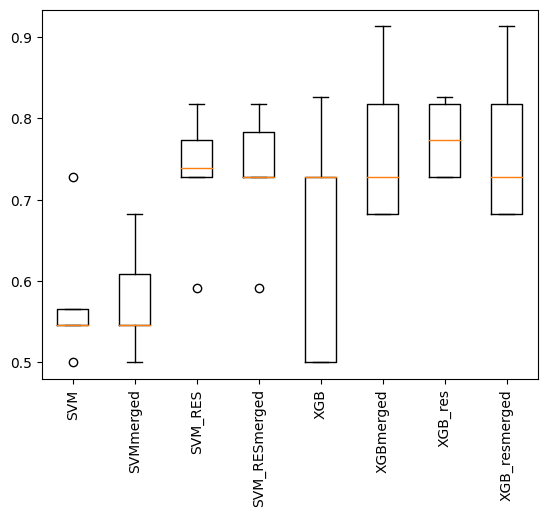

In [255]:
plt.boxplot(rec,labels=titles)
plt.xticks(rotation=90)
plt.title("Recall for Fail class")

Considering the results the algorithm XGB without merging the classes is considered the most reliable, and is therefore trained with the whole dataset and ran on the test dataset

In [256]:
df = pd.read_csv(dataset_path+"/test_set_data_science.tsv", delimiter="\t")